In [33]:
# Libraries import
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, Operator, DensityMatrix
from qiskit_aer import AerSimulator

C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:47: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:60: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.h(1).c_if(0, 0)
C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:70: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.cx(0, 1).c_if(0, 1)


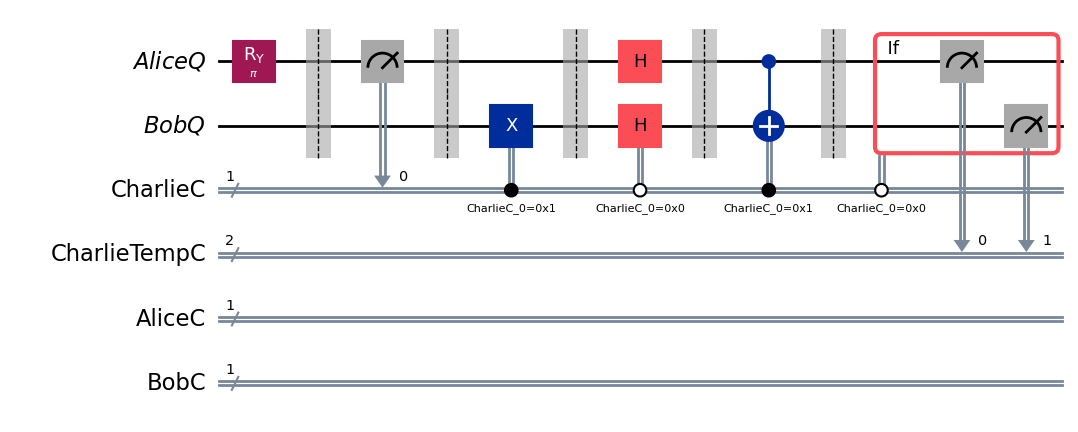

In [34]:

# Get Qiskit version
qiskit_version = qiskit.version.get_version_info()

def specialized_werner_states_generator(theta: float, circuitname: str = None) -> QuantumCircuit:
    """
    A specialized circuit for generating Werner states with a given parameter theta.

    Args:
        theta: The parameter theta for the Werner state (in radians).
        circuitname: The name of the quantum circuit.
    
    Returns:
        A QuantumCircuit that generates the Werner state.
    """

    # Quantum Circuit:
    #  - 1st qubit is of Alice
    #  - 2nd qubit is of Bob
    #  ---------------------
    #  - 1st classical bit is used by Charlie for generating the Werner state
    #  - 2nd and 3rd classical bits are used by Charlie as the "temp" classical register
    #  - 4th classical bit is used by Alice
    #  - 5th classical bit is used by Bob

    tempC = ClassicalRegister(2, "CharlieTempC")

    qc = QuantumCircuit(QuantumRegister(1, "AliceQ"), 
                        QuantumRegister(1, "BobQ"), 
                        ClassicalRegister(1, "CharlieC"), 
                        tempC,
                        ClassicalRegister(1, "AliceC"),
                        ClassicalRegister(1, "BobC"),
                        name=circuitname)

    # Apply the R_y(theta) gate to the first qubit
    qc.ry(theta, 0)

    qc.barrier()

    # Measure the first qubit
    qc.measure(0, 0)

    qc.barrier()

    # Apply X gate on the second qubit if the measurement outcome is 1
    if int(qiskit_version.split('.')[0]) < 2:
        qc.x(1).c_if(0, 1)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 1)):
            qc.x(1)

    qc.barrier()

    # Apply Hadamard gate on the first qubit
    qc.h(0)

    # Apply Hadamard gate on the second qubit if the measurement outcome is 0
    if int(qiskit_version.split('.')[0]) < 2:
        qc.h(1).c_if(0, 0)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 0)):
            qc.h(1)

    qc.barrier()

    # Apply CNOT gate if the measurement outcome is 1
    if int(qiskit_version.split('.')[0]) < 2:
        qc.cx(0, 1).c_if(0, 1)
    else: 
        # From Qiskit 2.0.0.
        with qc.if_test((0, 1)):
            qc.cx(0, 1)

    qc.barrier()

    # Measure both qubits if the previous measurement outcome is 0
    # We do not want to preserve the results of these measurements.
    # For this reason we use the "tempC" classical register with 2 bits.
    if int(qiskit_version.split('.')[0]) < 2:
        # WARNING: The condition is not correctly specified for the measurement operation.
        # So we need to use the new if_test method.
        #
        # qc.measure([0, 1], [tempC[0], tempC[1]]).c_if(0, 0)
        #
        with qc.if_test((0, 0)):
            qc.measure([0, 1], [tempC[0], tempC[1]])
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 0)):
            qc.measure([0, 1], [tempC[0], tempC[1]])

    return qc



qc = specialized_werner_states_generator(np.pi)
# draw the circuit
qc.draw('mpl')
    

In [35]:
# The following structure will be used to store all the information
# related to the nodes in the network (Alice and Bob)
Nodes = {}

# Alice and Bob are the two parties
Nodes["Alice"] = {}
Nodes["Bob"] = {}

In [36]:
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

# Alice's observables
Nodes["Alice"]["observables"] = []
# A0
Nodes["Alice"]["observables"].append(Z)
# A1
Nodes["Alice"]["observables"].append(X)
# A2
Nodes["Alice"]["observables"].append((Z + X) / np.sqrt(2))

# Bob's observables
Nodes["Bob"]["observables"] = []
# B0
Nodes["Bob"]["observables"].append(Z)
# B1
Nodes["Bob"]["observables"].append((Z - X) / np.sqrt(2))
# B2
Nodes["Bob"]["observables"].append((Z + X) / np.sqrt(2))

In [37]:
# Before performing the measurements using such observables,
# we need to do the following:
#   1. Compute eigenvalues and eigenvectors of each observable.
#   2. Find the unitary transformation that maps the eigenvalues of the observables to the standard basis.
#   3. Apply the found unitary transformation to the qubits before measuring them (in the standard basis).
#   4. This is as if we are measuring the qubits using the observables.


for node in Nodes:
    
    Nodes[node]["unitaries"] = []

    for i in range(len(Nodes[node]["observables"])):
        
        # Step 1: Compute eigenvalues and eigenvectors of each observable.
        eigenvalues, eigenvectors = np.linalg.eig(Nodes[node]["observables"][i])

        # Step 2: Find the unitary transformation that maps the eigenvalues of the observables to the standard basis.

        # Constructing the coefficient matrix of the linear system to solve
        A = np.array([[eigenvectors[:,0][0], eigenvectors[:,0][1], 0, 0], [0, 0, eigenvectors[:,0][0], eigenvectors[:,0][1]], [eigenvectors[:,1][0], eigenvectors[:,1][1], 0, 0], [0, 0, eigenvectors[:,1][0], eigenvectors[:,1][1]]])

        # Vector of the known terms
        b = np.array([1, 0, 0, 1])

        # Solve the system
        x = np.linalg.solve(A, b)

        # Construct the unitary transformation matrix
        U = np.array([[x[0], x[1]], [x[2], x[3]]])
        
        # Checking if the matrix is unitary
        assert np.allclose(np.eye(2), U @ U.conj().T)

        Nodes[node]["unitaries"].append(U)


In [38]:
# Now we can prepare the measurements circuits using the unitaries we have just found.

for node in Nodes:
    
    Nodes[node]["measurement_circuits"] = []

    for i in range(len(Nodes[node]["unitaries"])):
        
        # Create a quantum circuit with 1 qubit and 1 classical bit
        qc = QuantumCircuit(QuantumRegister(1, "oQ"), ClassicalRegister(1, "oC"))

        # Apply the unitary transformation to the qubits
        qc.unitary(Nodes[node]["unitaries"][i], 0)

        # Transplie the circuit 
        transpiled_qc = transpile(qc, basis_gates=['u3', 'cx'])

        # Measure the qubit
        transpiled_qc.measure(0, 0)
        
        # transpiled_qc.global_phase = 0

        Nodes[node]["measurement_circuits"].append(transpiled_qc)

In [39]:
key_length = 100
# Trovare formula che leghi epr_pairs a key_length
epr_pairs = 500

import random

# Alice and Bob randomly choose the bases for their measurements
for node in Nodes:
    Nodes[node]["bases"] = [random.randint(0, 2) for i in range(epr_pairs)]

In [40]:
QCs = []

for i in range(epr_pairs):
    circuitname = str(i) + ':A'+str(Nodes["Alice"]["bases"][i])+'_B'+str(Nodes["Bob"]["bases"][i])

    # Getting the quantum circuit from the specialized_werner_states_generator 
    qc = specialized_werner_states_generator(np.pi, circuitname=circuitname)

    qc.barrier()

    qc.append(Nodes["Alice"]["measurement_circuits"][Nodes["Alice"]["bases"][i]], [0], [3])
    qc.append(Nodes["Bob"]["measurement_circuits"][Nodes["Bob"]["bases"][i]], [1], [4])

    transpiled_qc = transpile(qc, basis_gates=['x', 'y', 'z', 'h', 'u3', 'cx'], optimization_level=0)

    QCs.append(transpiled_qc)
    

C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:47: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:60: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.h(1).c_if(0, 0)
C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:70: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.cx(0, 1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipykernel_23608\3626593452.py:47: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(1).c_if(0, 1)
C:\Users\giova\AppData\Local\Temp\ipyker

Circuit: 0:A2_B1


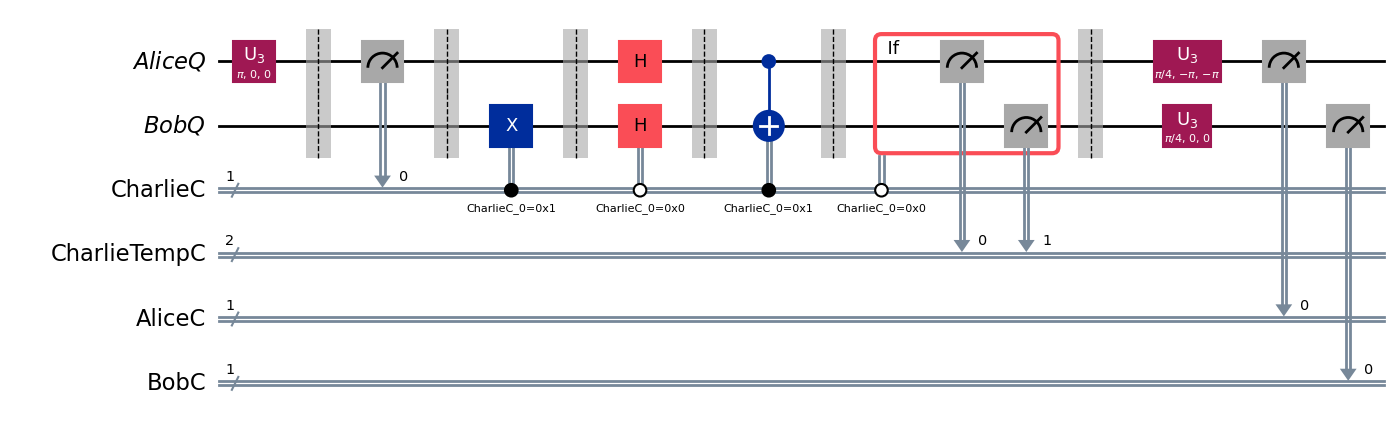

In [41]:
# Let's draw a circuit for debugging purposes
print(f"Circuit: {QCs[0].name}")
QCs[0].draw('mpl')

In [42]:
# It's time now to simulate the circuits and extract the results.
from qiskit.result import marginal_counts

simulator = AerSimulator()

result = simulator.run(QCs, shots=1).result()

In [43]:

for i, node in enumerate(Nodes):
    Nodes[node]["results"] = []
    for j in range(epr_pairs):

        counts = result.get_counts(QCs[j])

        # Here I do the following:
        #
        # 1. `marginal_counts(counts, indices=[3, 4])`: Computes the marginal counts for the given indices [3, 4] from the `counts` data.
        # 2. `list(...).keys()`: Converts the keys of the resulting dictionary to a list.
        # 3. `list(...)[0]`: Retrieves the first key from the list of keys. That is also the only one, having run the circuit with `shots=1`.
        # 4. `[::-1]`: Reverses the string, because (before the reversion) the classical bit of Alice is the one on the right and the classical bit of Bob is the one on the left.
        # 5. `[i]`: Retrieves the i character from the reversed string. If i=0, we get the classical bit of Alice. If i=1, we get the classical bit of Bob.
        result_i = list(marginal_counts(counts, indices=[3, 4]).keys())[0][::-1][i]

        # If result_i == 0 append -1, otherwise append 1
        Nodes[node]["results"].append(-1 if result_i == '0' else 1)

In [44]:
# At this point the Bases of Alice and Bob can be revealed via the public classical channel.
# And Alice and Bob can create the shared key.

# The cases where Alice and Bob measured onto the same direction are:
# A0 and B0
# A2 and B2

for node in Nodes:
    Nodes[node]["key"] = []

for i in range(epr_pairs):

    if Nodes["Alice"]["bases"][i] == Nodes["Bob"]["bases"][i]:
        
        if Nodes["Alice"]["bases"][i] == 0 or Nodes["Alice"]["bases"][i] == 2:
            
            # Append 0 if the i-th result is -1, otherwise append 1
            Nodes["Alice"]["key"].append(0 if Nodes["Alice"]["results"][i] == -1 else 1)

            # In such cases the result measured by Bob is perfectly anti-correlated with the one measured by Alice.
            # So to get a correlated result it is sufficient to multiply the result of Bob by -1.

            Bob_result = - Nodes["Bob"]["results"][i]
        
            # Now we can append a new bit in the key of Bob as before
            Nodes["Bob"]["key"].append(0 if Bob_result == -1 else 1)
    

In [45]:
# Alice and Bob keys
''.join(map(str, Nodes["Alice"]["key"])), ''.join(map(str, Nodes["Bob"]["key"]))

('100111110100001100110110000000001111000101110111000110110010000011011000000111101110101000011110010000100101',
 '100111110100001100110110000000001111000101110111000110110010000011011000000111101110101000011110010000100101')

In [46]:
mismatch_key_bits = 0

for i in range(len(Nodes["Alice"]["key"])):
    if Nodes["Alice"]["key"][i] != Nodes["Bob"]["key"][i]:
        mismatch_key_bits += 1

mismatch_key_bits

0

In [47]:
def chsh(epr_pairs: int, Nodes: dict) -> float:
    """
    Computes the CHSH correlation value.

    Args:
        epr_pairs (int): The number of EPR pairs used in the experiment.
        Nodes (dict): The dictionary containing the parties involved in the protocol.
    
    Returns:
        float: The CHSH correlation value.
    """

    def compute_expectation(counts):
        """
        Computes the expectation value (the Quantum Correlation) from the given counts.

        Args:
            counts (dict): Dictionary containing counts of measurement outcomes.
        
        Returns:
            float: The computed expectation value.
        """
        total = sum(counts.values())
        return (counts[(-1, -1)] - counts[(1, -1)] - counts[(-1, 1)] + counts[(1, 1)]) / total


    # Initialize counts for the observable combinations needed for the CHSH
    # A0B1, A0B2, A1B1, A1B2
    # The keys represent the observable combinations (Alice's observable, Bob's observable)
    # The values are dictionaries with the counts of measurement outcomes:
    #   In these dictionaries, the keys represent the measurement outcomes of Alice and Bob respectively
    #   The values represent the counts of the corresponding outcomes
    counts = {
        (0, 1): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
        (0, 2): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
        (1, 1): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
        (1, 2): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
    }

    # Iterate through all EPR pairs and update counts
    for i in range(epr_pairs):
        
        Alice_observable = Nodes["Alice"]["bases"][i]
        Bob_observable = Nodes["Bob"]["bases"][i]

        if (Alice_observable, Bob_observable) in counts:

            Alice_result = Nodes["Alice"]["results"][i]
            Bob_result = Nodes["Bob"]["results"][i]

            counts[(Alice_observable, Bob_observable)][(Alice_result, Bob_result)] += 1


    # Compute expectation values for each observable combination
    expect_A0B1 = compute_expectation(counts[(0, 1)])
    expect_A0B2 = compute_expectation(counts[(0, 2)])
    expect_A1B1 = compute_expectation(counts[(1, 1)])
    expect_A1B2 = compute_expectation(counts[(1, 2)])

    # Calculate the CHSH correlation value
    # S = | <A0B2> + <A0B1> + <A1B2> - <A1B1> |
    S = abs(expect_A0B2 + expect_A0B1 + expect_A1B2 - expect_A1B1)

    return S


In [48]:
# Computing the CHSH correlation value
chsh_correlation = chsh(epr_pairs, Nodes)
print(f"CHSH correlation value: {round(chsh_correlation,5)}")

CHSH correlation value: 2.88135
